## 1) Model building: Latent Dirichlet Allocation for uncovering latent topics in the corpus

Description: the notebook is broken down into the following sections:

1) Model tuning (hyperparameter selection) - decide ont he number of topics to use in the model based on the perplexity score on a held out test set.

2) Model evaluation and ranking predictions - plot topic distributions and identify similar films for a number of test films


LDA code was adapted from: [scikit_learn](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py) - Authors: Olivier Grisel, Lars Buitinck, Chyi-Kwei Yau - License: BSD 3 clause

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import time
import pickle
import gradio as gr

from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

c:\Users\Nick\.conda\envs\recsys_movie\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1a) Hyperparameter selection - number of topics to choose

In [4]:
# read in movie database
df = pd.read_csv("data_preprocessing_eda_out\\df_spaces_upload.csv", index_col=[0])

# read in scipy sparse matrix
X = sparse.load_npz("data_preprocessing_eda_out\\X.npz")

with open("data_preprocessing_eda_out\\word_key.txt", "rb") as f:
    word_key = pickle.load(f)

n_movies = len(df)
n_features = len(word_key)

In [5]:
# model inputs
n_samples = 8000
n_components = 20
n_top_words = 20

# construct train/test split
X_train, X_test = train_test_split(X, train_size=n_samples, test_size=2000, random_state=22)

In [ ]:
# hyperparameter selection - number of topics (n_components)
n_components = np.array([2, 4, 8, 12, 16, 24, 32, 40, 50, 64])
for ncomp in n_components:
    print(f"")
    lda = LatentDirichletAllocation(
        n_components=ncomp,  # x4 components 2.5x the time
        max_iter=40,  # x2 iterations 2x the time
        learning_decay=0.55,
        learning_method="online",
        learning_offset=64.0,
        batch_size=256,
        random_state=0,
        evaluate_every=4,
        verbose=1,
    )
    lda.fit(X_train)  # scales (roughly) linearly with number of training examples
    p_train = np.round(lda.perplexity(X_train), 1)
    p_test = np.round(lda.perplexity(X_test), 1)
    print(f"n_components = {ncomp}: p_train = {p_train}, p_test = {p_test}")

In [17]:
# fit LDA model with optimal value for n_components

# took 90 minutes (~1.75 minutes/iteration) on 10,000 words, 20 components, 10177 randomly chosen samples, 52 iterations, perplexity dropped <0.1/iteration at 52th iteration
print(
    f"Fitting LDA models with tf features, n_samples={n_samples} and n_features={n_features}..."
)
lda = LatentDirichletAllocation(
    n_components=n_components,  # x4 components 2.5x the time
    max_iter=30,  # x2 iterations 2x the time
    learning_decay=0.55,
    learning_method="online",
    learning_offset=64.0,
    batch_size=256,
    random_state=0,
    evaluate_every=5,
    verbose=1,
)
t0 = time.time()
lda.fit(X_train)  # scales (roughly) linearly with number of training examples
print("done in %0.3fs." % (time.time() - t0))

print(lda.perplexity(X_test))

Fitting LDA models with tf features, n_samples=8000 and n_features=10000...
iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30, perplexity: 2798.1047
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30, perplexity: 2779.2717
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30, perplexity: 2772.2392
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30, perplexity: 2768.6466
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30, perplexity: 2766.3787
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteratio

## 2) Model evaluation

In [2]:
lda = pickle.load(open('model_building_and_eval\\model_2023_08_16.sav', 'rb'))
with open("model_building_and_eval\\Xtran.txt", "rb") as f:
    Xtran = pickle.load(f)

In [4]:
# predict topic weights for all scripts in the database (4 minutes for the entire corpus)
# this will be precomputed and saved to be used for recommender app predicitons
Xtran = lda.transform(X)


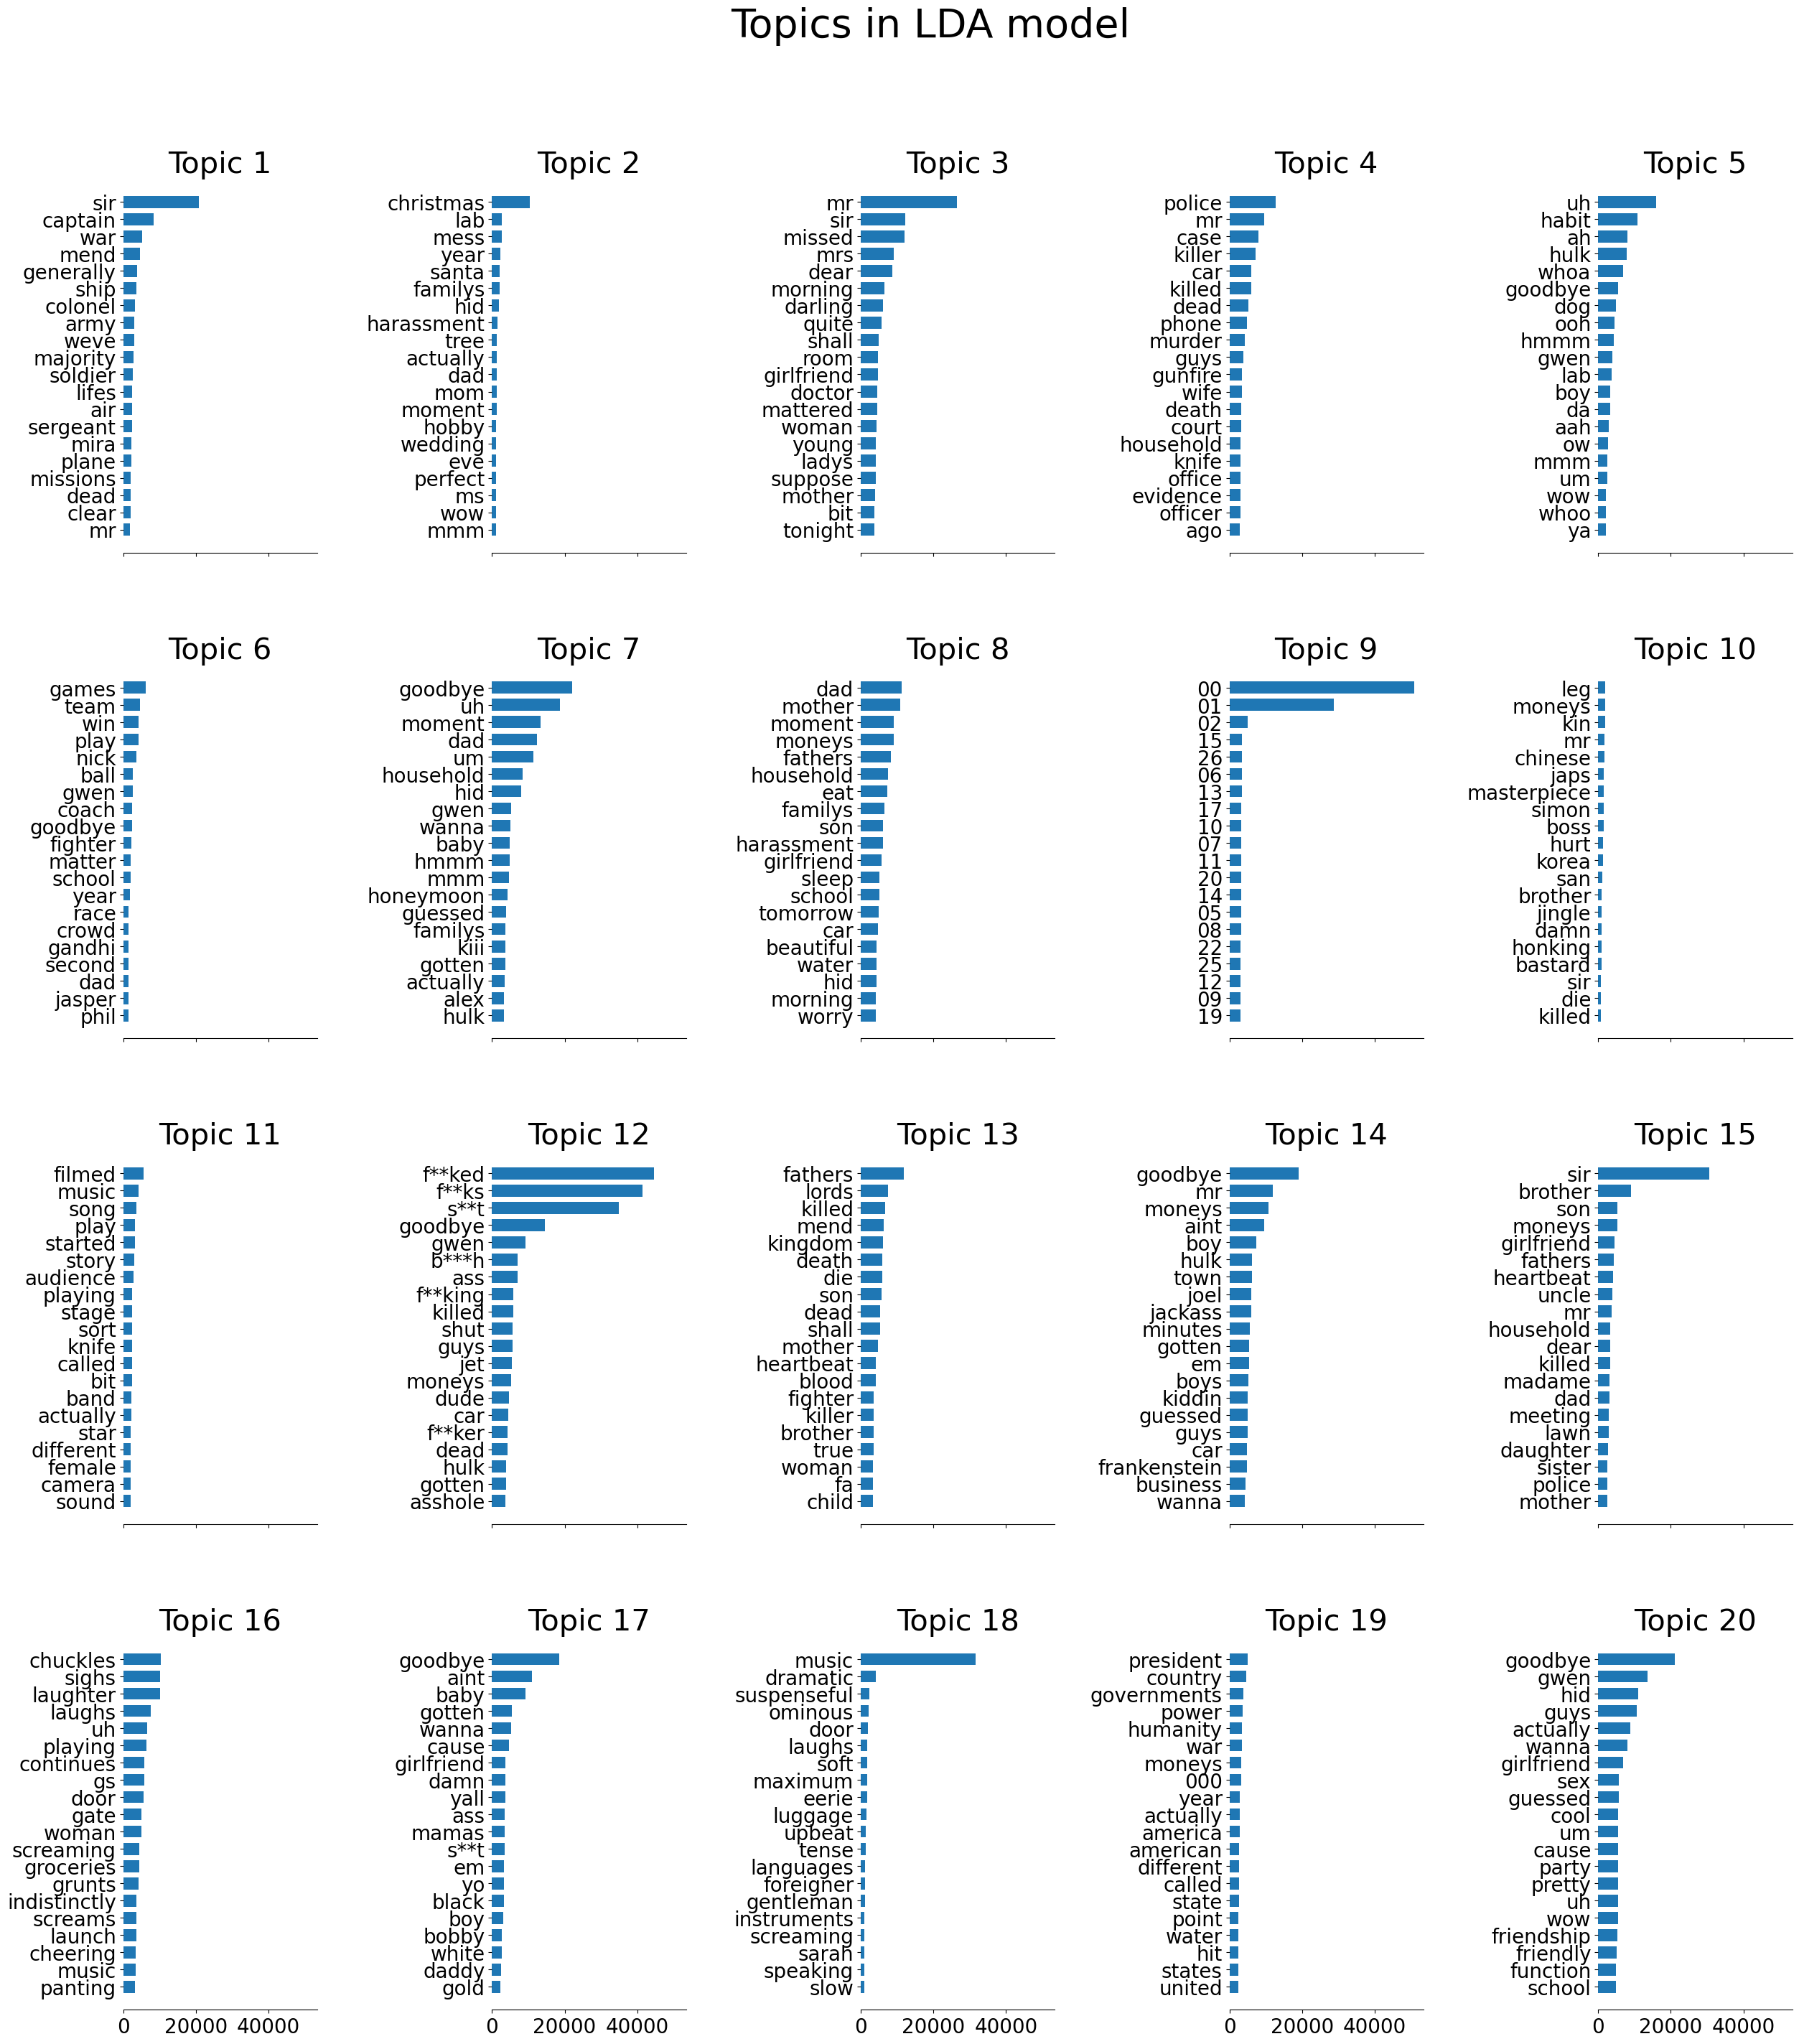

In [6]:
def plot_top_words(model, feature_names, n_top_words, n_components, title):
    # output: plot of top n_top_words for each topic in the model
    fig, axes = plt.subplots(
        int(np.ceil(n_components / 5)),
        5,
        figsize=(30, 30 * n_components / 20),
        sharex=True,
    )
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda, word_key, n_top_words, n_components, "Topics in LDA model")

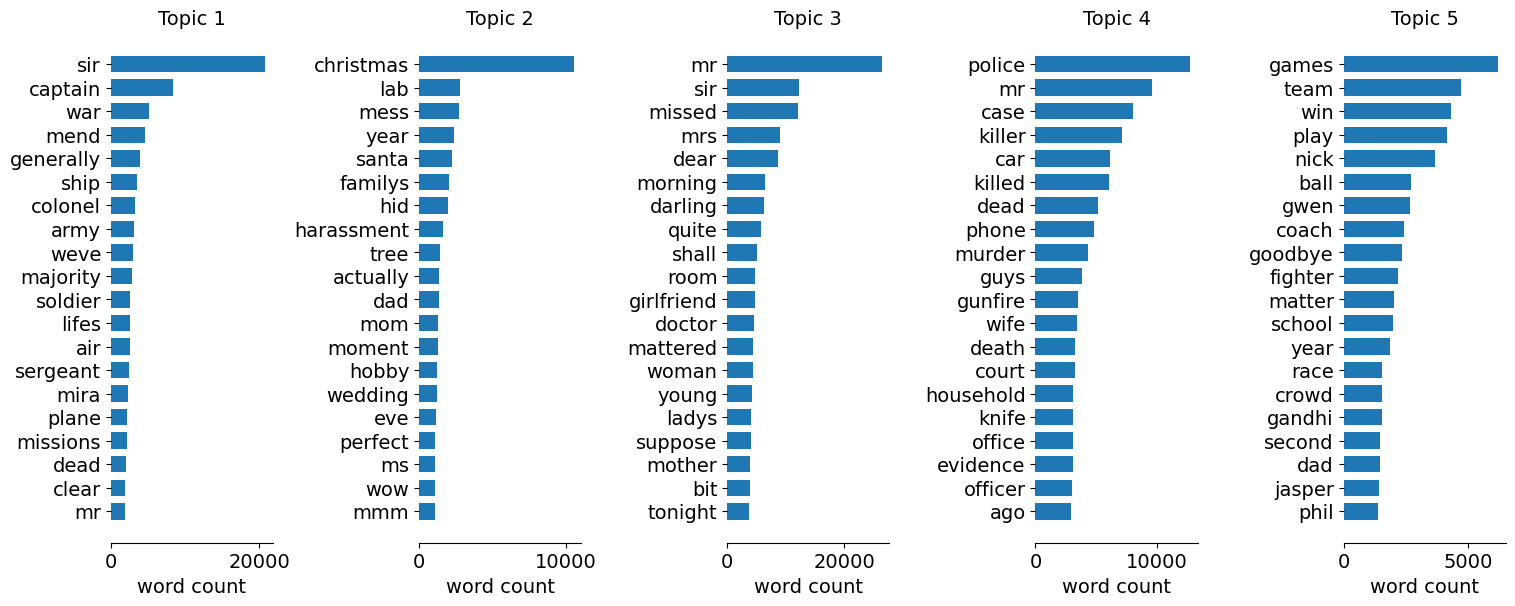

In [10]:
def plot_top_words_selected_topics(
    model, feature_names, n_top_words, n_components, title, select_topics
):
    # output: plot of top n_top_words for each topic in the model
    fig, axes = plt.subplots(
        1,
        5,
        figsize=(18, 6),
        sharex=False,
    )
    axes = axes.flatten()
    kk = -1
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx in select_topics:
            kk = kk + 1
            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[kk]
            ax.barh(top_features, weights, height=0.7)
            ax.set_title(f"Topic {kk+1}", fontdict={"fontsize": 14})
            ax.invert_yaxis()
            ax.tick_params(axis="both", which="major", labelsize=14)
            ax.set_xlabel("word count", fontdict={"fontsize": 14})
            for i in "top right left".split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=18)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

    return fig


fig = plot_top_words_selected_topics(
    lda, word_key, n_top_words, n_components, "", [0, 1, 2, 3, 5]
)
fig.figure.savefig('model_building_and_eval\\select_topics.png', dpi=450, bbox_inches="tight")

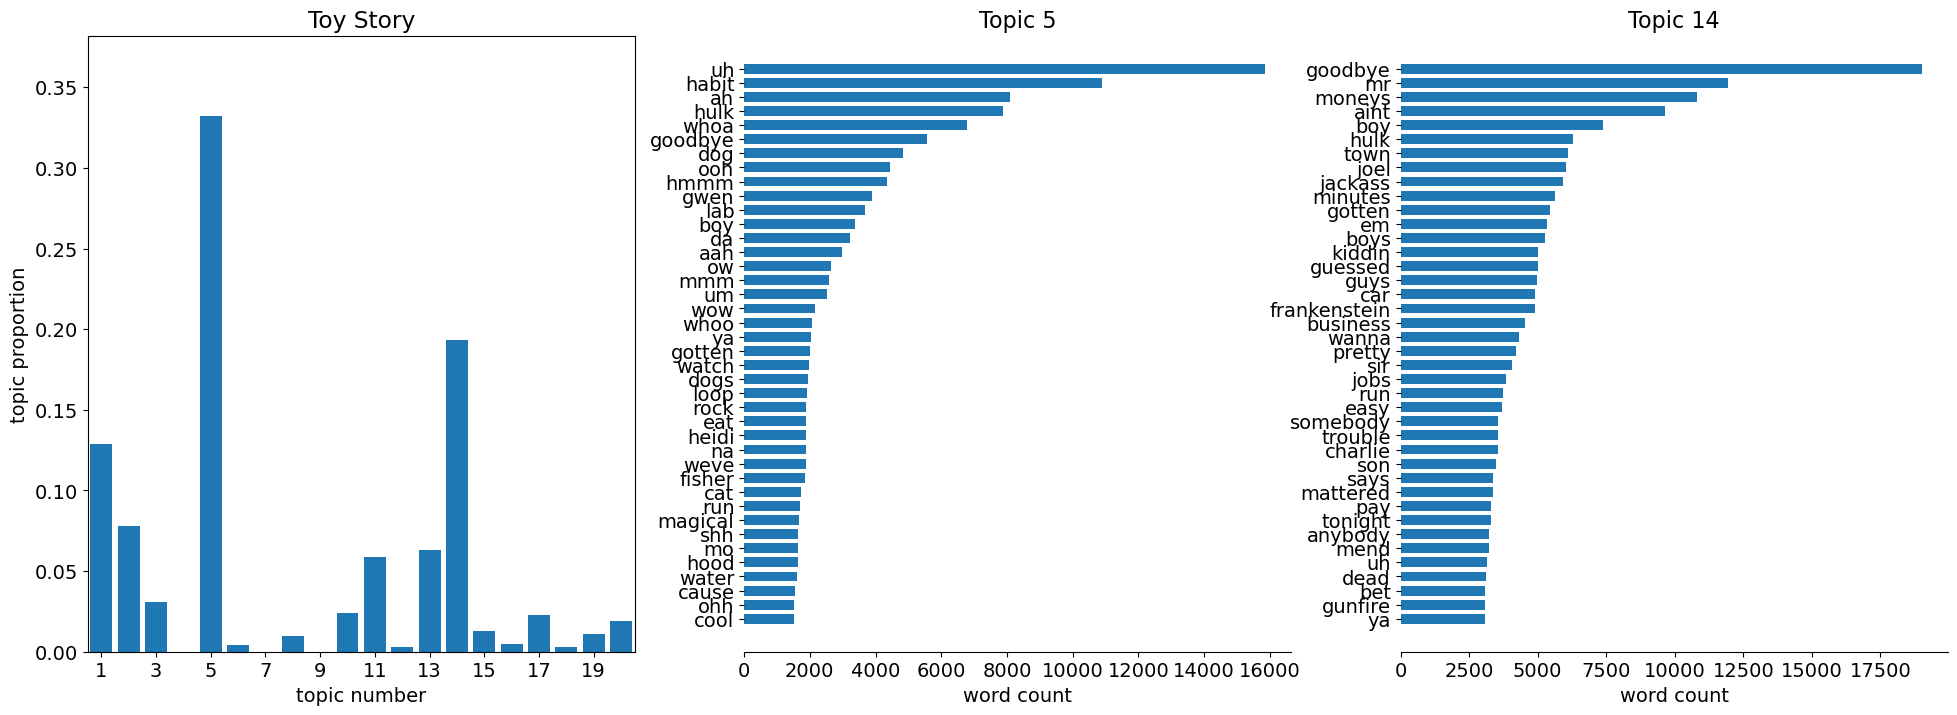

In [93]:
# define some test cases - will be used as examples in app
plt.rcParams.update({'font.size': 14})
tested_examples = [
    ["Toy Story", "7.1", True],
]

# visualize the topic distribution for tested_examples

# plot distribution of topic weights


for j, ex in enumerate(tested_examples):
    fig, ax = plt.subplots(1, 3, figsize=(24, 8))
    ax = ax.flatten()
    jmovie = df[df["movie_title"] == ex[0]].index[0]
    prob_height = np.round(Xtran[jmovie, :].reshape(1, n_components), 3).reshape(-1)
    arg_topic = np.flip(np.argsort(prob_height))
    ax[0].bar(x=list(range(1, n_components + 1)), height=prob_height)
    ax[0].set_ylim(0, np.max(prob_height) + 0.05)
    ax[0].set_xlim(0.5, n_components + 0.5)
    ax[0].set_ylabel("topic proportion")
    ax[0].set_xlabel("topic number")
    ax[0].set_title(ex[0])
    ax[0].set_xticks(list(range(1, n_components + 1, 2)))

    kk = 0
    for topic_idx, topic in enumerate(lda.components_):
        if topic_idx in arg_topic[0:2]:
            kk = kk + 1
            top_features_ind = topic.argsort()[: -40 - 1 : -1]
            top_features = [word_key[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax[kk].barh(top_features, weights, height=0.7)
            ax[kk].set_title(f"Topic {arg_topic[kk-1]+1}", fontdict={"fontsize": 16})
            ax[kk].invert_yaxis()
            ax[kk].tick_params(axis="both", which="major", labelsize=14)
            ax[kk].set_xlabel("word count", fontdict={"fontsize": 14})
            for i in "top right left".split():
                ax[kk].spines[i].set_visible(False)

# fig.figure.savefig('model_building_and_eval\\schindlers_list_top_topics.png', dpi=450, bbox_inches="tight")

# 2) Model prediction and ranking of recommendations

In [8]:
def movie_rec(movie_name, rating_min, is_adult):
    # compute top 5 movie recommendations for the input movie and filters
    # inputs:
    #       movie_name: selected movie_name from radio
    #       rating_min: filter out all movies with ratings less than rating_min
    #       is_adult: if True then filter out adult titles
    # ouputs:
    #       df_in: dataframe with all the info on movie_name
    #       df_out: dataframe with all the info on top 5 recommended movies

    if not movie_name:
        raise gr.Error("Please select a movie before clicking Recommend")

    jmovie = df[df["movie_title"] == movie_name].index[0]
    sim_in = Xtran[jmovie, :].reshape(1, Xtran.shape[1])

    if "NULL" in df["imdb_link"].iloc[jmovie]:
        # input movie has no matching IMDb title
        link_in = ["N/A"]
        genre_in = ["N/A"]
        rating_in = ["N/A"]
    else:
        # link_in = construct_markdown_link([df["imdb_link"].iloc[jmovie]], [movie_name])
        genre_in = [df["genre"].iloc[jmovie]]
        rating_in = [df["average_rating"].iloc[jmovie]]

    # construct input dataframe
    df_in = pd.DataFrame(
        {
            "Title": [movie_name],
            "Year": [df["movie_year"].iloc[jmovie]],
            "IMDb Rating": rating_in,
            "Genres": genre_in,
            # "IMDb Link": link_in,
        }
    )

    # compute similarity between movie_name and all other movies in database
    sim_movie = cosine_similarity(sim_in, Xtran).reshape((len(df),))

    # sort dataframe by movie similarity in descending order
    arg_sim_movie_ordered = np.flip(np.argsort(sim_movie))
    df_sort = df.iloc[arg_sim_movie_ordered[1:]]

    # fiter by rating_min and is_adult
    df_sort = df_sort[df_sort["average_rating"] >= float(rating_min)]
    if is_adult:
        df_sort = df_sort[df_sort["is_adult"] == 0]

    # raise error if less than 5 movies are left after filtering
    if len(df_sort) < 5:
        raise gr.Error(
            "Not enough movies met the filter criteria. Try reducing the minimum rating."
        )

    # construct output dataframe
    movie_title = df_sort["movie_title"].iloc[0:5].tolist()
    movie_year = df_sort["movie_year"].iloc[0:5].tolist()
    rating = df_sort["average_rating"].iloc[0:5].tolist()
    genre = df_sort["genre"].iloc[0:5].tolist()
    # link = construct_markdown_link(df_sort["imdb_link"].iloc[0:5].tolist(), movie_title)

    df_out = pd.DataFrame(
        {
            "Title": movie_title,
            "Year": movie_year,
            "IMDb Rating": rating,
            "Genres": genre,
            # "IMDb Link": link,
        }
    )

    return df_in, df_out

## Finally, export model to be deployed with recommender app

In [9]:
# pickle.dump(lda, open('model_building_and_eval\\model_2023_08_16.sav', 'wb'))

with open('model_building_and_eval\\Xtran.txt', 'wb') as f:
    pickle.dump(Xtran,f)    